In [1]:
# === Environment Setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from IPython.display import display, Markdown

# --- Configuration ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14, 'figure.figsize': (12, 8), 'figure.dpi': 150})
np.set_printoptions(suppress=True, linewidth=120, precision=4)

# --- Utility Functions ---
def note(msg): display(Markdown(f"<div class='alert alert-info'>📝 {msg}</div>"))
def sec(title): print(f'\n{80*"="}\n| {title.upper()} |\n{80*"="}')

note("Environment initialized for ARMA Models.")

<div class='alert alert-info'>📝 Environment initialized for ARMA Models.</div>

# Chapter 8.2: Autoregressive and Moving Average (ARMA) Models

---

### Table of Contents

1.  [**Introduction: Modeling Stationary Time Series**](#intro)
2.  [**Autoregressive (AR) Models**](#ar)
    - [Code Lab: Simulating and Estimating an AR(2) Process](#code-ar)
3.  [**Moving Average (MA) Models**](#ma)
    - [Code Lab: Simulating and Estimating an MA(2) Process](#code-ma)
4.  [**Autoregressive Moving Average (ARMA) Models**](#arma)
    - [Code Lab: Simulating and Estimating an ARMA(1,1) Process](#code-arma)
5.  [**The Box-Jenkins Methodology**](#box-jenkins)
6.  [**Information Criteria for Model Selection**](#info-criteria)
7.  [**Exercises**](#exercises)
8.  [**Summary and Key Takeaways**](#summary)

<a id='intro'></a>
## 1. Introduction: Modeling Stationary Time Series

This chapter introduces the foundational models for stationary time series: the **Autoregressive (AR)**, **Moving Average (MA)**, and combined **ARMA** models. While these models are most famously associated with the work of George Box and Gwilym Jenkins in the 1970s, their intellectual roots go back further.

The concept of autoregression was introduced by **Udny Yule** in 1927 in a study of sunspot cycles, where he modeled the current number of sunspots as a function of past numbers. The moving average component was introduced by **Herman Wold** in his 1938 thesis, which established the theoretical foundations for stationary time series. Wold's Decomposition Theorem showed that any stationary process can be represented as the sum of a deterministic component and a moving average of infinite order.

Box and Jenkins built on this work by developing a practical, iterative methodology for identifying, estimating, and diagnosing **ARMA models**. These models provide a parsimonious way to model the conditional mean of a stationary process by relating it to its own past values (the AR part) and to past forecast errors (the MA part).

Understanding these models is crucial for forecasting and for providing a baseline against which more complex models can be compared.

<a id='ar'></a>
## 2. Autoregressive (AR) Models

An **Autoregressive model of order p**, denoted AR(p), models the current value of the series, $y_t$, as a linear combination of its own $p$ previous values, plus a white noise error term $\epsilon_t$.

$$ y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t $$

Where:
- $y_t$ is the value of the series at time $t$.
- $c$ is a constant (the mean of the process is $c / (1 - \sum \phi_i)$).
- $\phi_1, ..., \phi_p$ are the autoregressive coefficients.
- $\epsilon_t$ is a white noise error term, with $E[\epsilon_t] = 0$ and $E[\epsilon_t^2] = \sigma^2$.

### The Lag Operator
It is often convenient to use the **lag operator**, $L$, where $L y_t = y_{t-1}$. Using this notation, the AR(p) model can be written more compactly:

$$ (1 - \phi_1 L - \phi_2 L^2 - ... - \phi_p L^p) y_t = c + \epsilon_t $$

Or even more simply as:

$$ \phi(L) y_t = c + \epsilon_t $$

Where $\phi(L)$ is the **autoregressive characteristic polynomial**. For the AR process to be stationary, the roots of the characteristic equation $\phi(z) = 0$ must all lie *outside* the unit circle.

**Key Identification Characteristics:**
- **ACF:** The ACF of a stationary AR(p) process will decay exponentially or in a damped sine-wave pattern.
- **PACF:** The PACF of an AR(p) process will have a sharp cutoff after lag $p$. All partial autocorrelations beyond lag $p$ will be statistically insignificant.
This signature PACF cutoff is the primary tool for identifying the order of an AR model.
<a id='code-ar'></a>


| SIMULATING AND ESTIMATING AN AR(2) PROCESS |


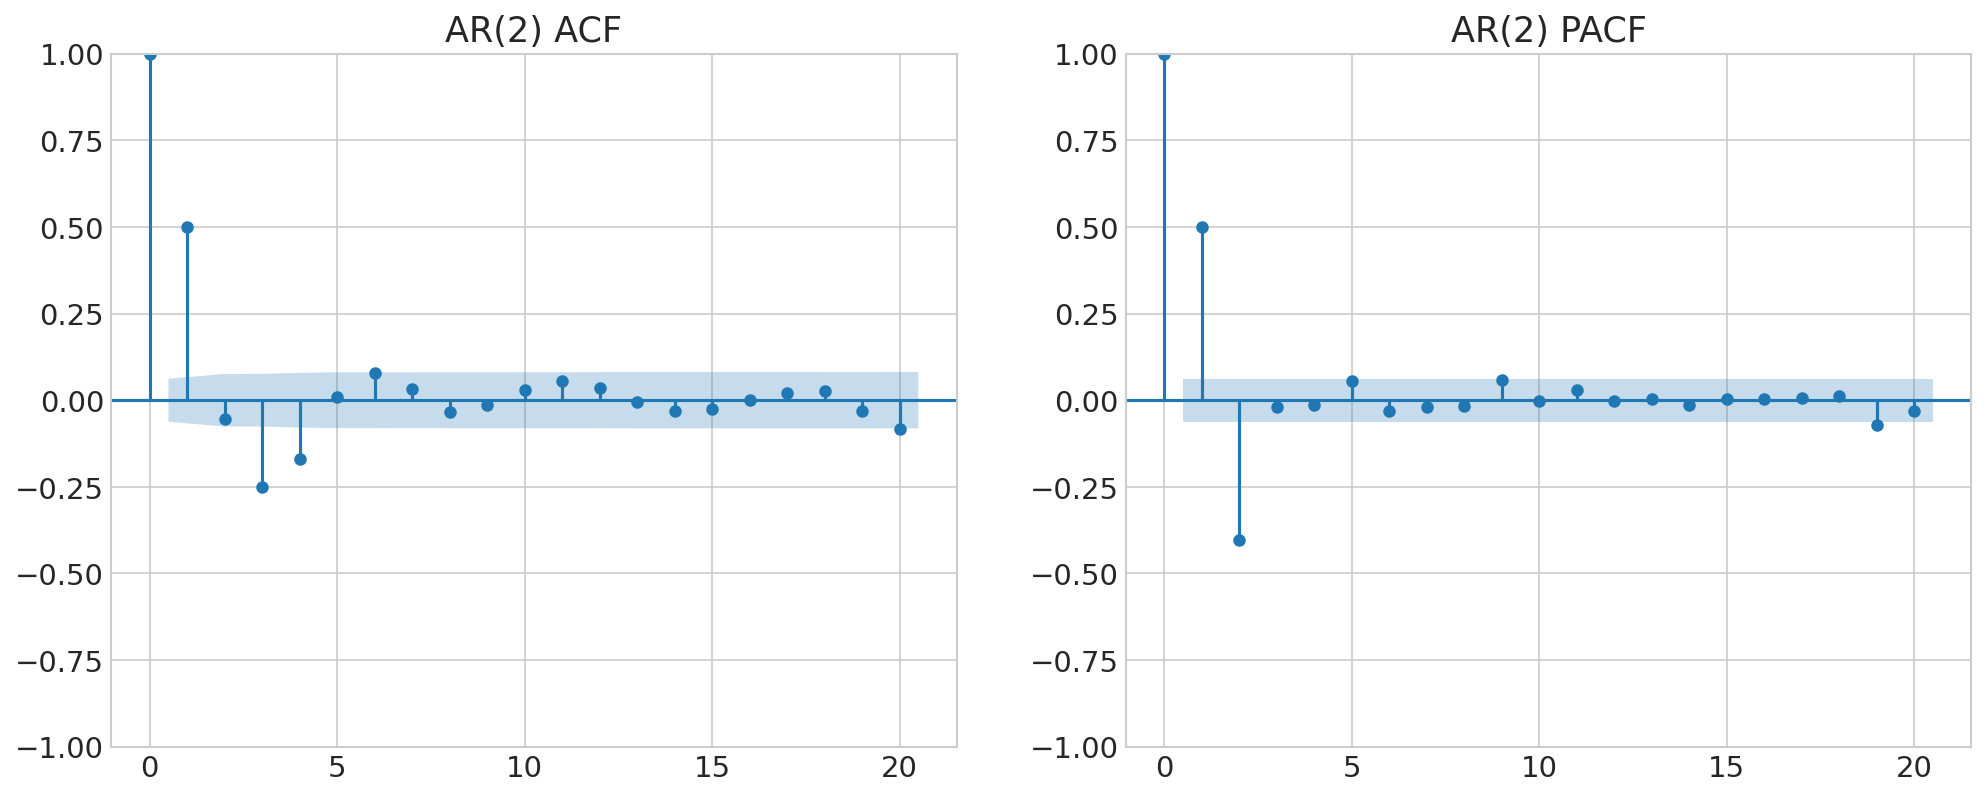

<div class='alert alert-info'>📝 The ACF tails off, while the PACF cuts off after lag 2, correctly identifying it as an AR(2) process.</div>

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1397.692
Date:                Wed, 22 Oct 2025   AIC                           2803.384
Time:                        10:13:40   BIC                           2823.015
Sample:                             0   HQIC                          2810.845
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0277      0.044      0.627      0.531      -0.059       0.114
ar.L1          0.6994      0.030     23.483      0.000       0.641       0.758
ar.L2         -0.4016      0.031    -13.135      0.0

In [2]:
sec("Simulating and Estimating an AR(2) Process")
np.random.seed(42)
n_samples = 1000

# --- 1. Data Generation ---
# Define the parameters for the AR(2) process: y_t = 0.7*y_{t-1} - 0.4*y_{t-2} + e_t
ar_params = np.array([0.7, -0.4]) # phi_1 = 0.7, phi_2 = -0.4
ma_params = np.array([]) # No MA component

# The arma_generate_sample function requires the AR parameters in a specific form:
# [1, -phi_1, -phi_2, ...]. This corresponds to the coefficients of the lag polynomial.
# np.r_ is a convenient way to concatenate arrays.
y = sm.tsa.arma_generate_sample(ar=np.r_[1, -ar_params], ma=np.r_[1, ma_params], nsample=n_samples)

# --- 2. Model Identification ---
# Plot the ACF and PACF to identify the model order.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(y, ax=ax1, lags=20, title='AR(2) ACF')
plot_pacf(y, ax=ax2, lags=20, title='AR(2) PACF')
plt.show()
note("The ACF tails off, while the PACF cuts off after lag 2, correctly identifying it as an AR(2) process.")

# --- 3. Model Estimation ---
# Specify the model order as (p, d, q). Here d=0 because the series is stationary.
model_ar = ARIMA(y, order=(2, 0, 0))
results_ar = model_ar.fit()

# --- 4. Results Interpretation ---
# The summary shows the estimated coefficients for ar.L1 (phi_1) and ar.L2 (phi_2).
# Compare these to our true parameters: phi_1=0.7 and phi_2=-0.4.
# The estimated values should be close to these, and their p-values (P>|z|) should be close to 0.
print(results_ar.summary())

<a id='ma'></a>
## 3. Moving Average (MA) Models

A **Moving Average model of order q**, denoted MA(q), models the current value of the series, $y_t$, as a linear combination of the current and $q$ previous white noise error terms.

$$ y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q} $$

An MA model can be thought of as modeling a series that experiences random shocks, where the effect of a shock persists for $q$ periods.

Using the lag operator, we can write the MA(q) process as:

$$ y_t = \mu + (1 + \theta_1 L + ... + \theta_q L^q) \epsilon_t $$

Or more compactly:
$$ y_t = \mu + \theta(L) \epsilon_t $$

Where $\theta(L)$ is the **moving average characteristic polynomial**.

**Key Identification Characteristics:**
- **ACF:** The ACF of an MA(q) process will have a sharp cutoff after lag $q$. All autocorrelations beyond lag $q$ will be zero.
- **PACF:** The PACF of an MA(q) process will decay exponentially or in a damped sine-wave pattern.
This signature ACF cutoff is the primary tool for identifying the order of an MA model.

### A Note on Invertibility
For an MA model to be useful, it must be **invertible**. An MA process is invertible if it can be represented as an infinite-order AR process. This property is crucial because it ensures that the model is unique and that the weights placed on past observations decline over time. The condition for invertibility is that the roots of the MA characteristic equation $\theta(z) = 0$ must lie *outside* the unit circle. This is analogous to the stationarity condition for AR models. All modern estimation packages, including `statsmodels`, enforce invertibility by default.
<a id='code-ma'></a>


| SIMULATING AND ESTIMATING AN MA(2) PROCESS |


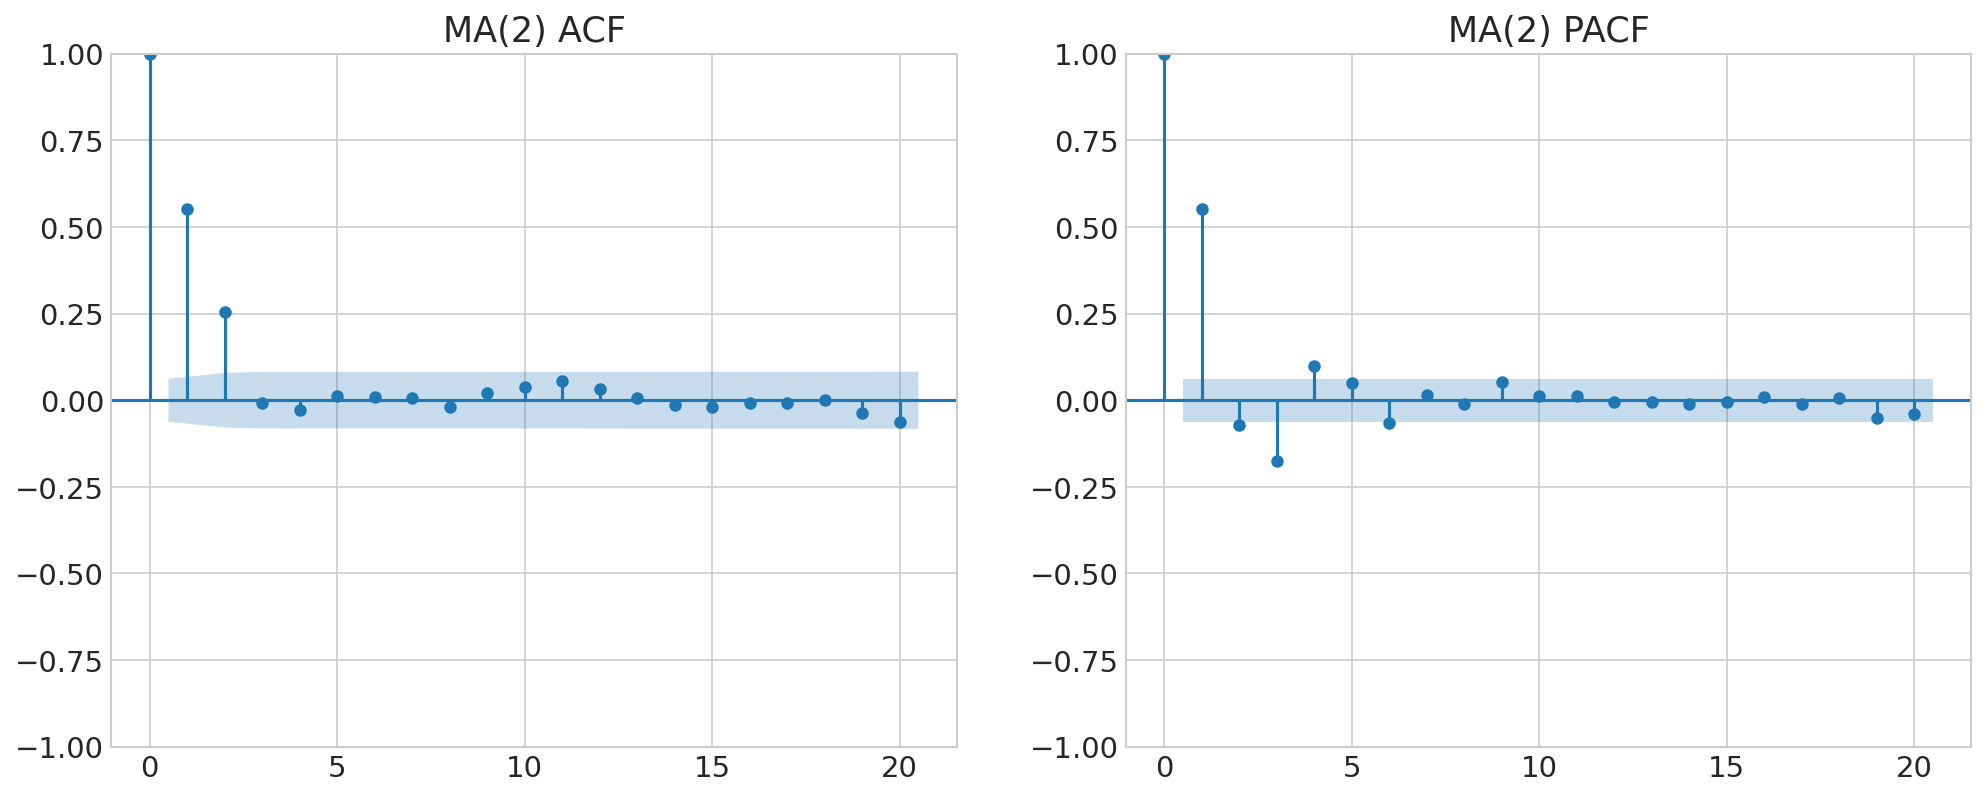

<div class='alert alert-info'>📝 The PACF tails off, while the ACF cuts off after lag 2, correctly identifying it as an MA(2) process.</div>

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1397.277
Date:                Wed, 22 Oct 2025   AIC                           2802.554
Time:                        10:13:41   BIC                           2822.185
Sample:                             0   HQIC                          2810.015
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0393      0.061      0.643      0.520      -0.080       0.159
ma.L1          0.5785      0.030     19.093      0.000       0.519       0.638
ma.L2          0.3873      0.030     12.745      0.0

In [3]:
sec("Simulating and Estimating an MA(2) Process")
np.random.seed(42)

# --- 1. Data Generation ---
# Define the parameters for the MA(2) process: y_t = e_t + 0.6*e_{t-1} + 0.4*e_{t-2}
ar_params = np.array([]) # No AR component
ma_params = np.array([0.6, 0.4]) # theta_1 = 0.6, theta_2 = 0.4

# The `arma_generate_sample` function requires the MA parameters to be specified as
# [1, theta_1, theta_2, ...].
y_ma = sm.tsa.arma_generate_sample(ar=np.r_[1, -ar_params], ma=np.r_[1, ma_params], nsample=n_samples)

# --- 2. Model Identification ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(y_ma, ax=ax1, lags=20, title='MA(2) ACF')
plot_pacf(y_ma, ax=ax2, lags=20, title='MA(2) PACF')
plt.show()
note("The PACF tails off, while the ACF cuts off after lag 2, correctly identifying it as an MA(2) process.")

# --- 3. Model Estimation ---
# Specify the model order as (p, d, q). Here p=0 and d=0.
model_ma = ARIMA(y_ma, order=(0, 0, 2))
results_ma = model_ma.fit()

# --- 4. Results Interpretation ---
# Compare the estimated coefficients ma.L1 (theta_1) and ma.L2 (theta_2) to the true
# parameters: theta_1=0.6 and theta_2=0.4.
print(results_ma.summary())

<a id='arma'></a>
## 4. Autoregressive Moving Average (ARMA) Models

An **ARMA(p,q)** model combines the AR(p) and MA(q) components:
\n\n> 📖 **First Principles: Parsimony**\n> In the context of statistical modeling, parsimony refers to the principle of explaining a phenomenon with the simplest possible model. A parsimonious model has just enough parameters to represent the underlying data structure without overfitting to noise. This approach is favored because it often leads to better generalization and forecasting performance.$$ y_t = c + \phi_1 y_{t-1} + ... + \phi_p y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q} $$

Using the lag operator, we can write this as:
$$ \phi(L) y_t = c + \theta(L) \epsilon_t $$

Where $\phi(L)$ is the AR polynomial and $\theta(L)$ is the MA polynomial. The process is stationary if the roots of the AR characteristic equation $\phi(z)=0$ lie outside the unit circle, and it is invertible if the roots of the MA characteristic equation $\theta(z)=0$ lie outside the unit circle.

**Key Identification Characteristics:**
- **ACF:** The ACF of an ARMA(p,q) process will decay exponentially. Its behavior for the first $q$ lags is determined by the MA part, and its decay pattern after lag $q$ is determined by the AR part.
- **PACF:** The PACF of an ARMA(p,q) process will also decay exponentially. Its behavior for the first $p$ lags is determined by the AR part, and its decay pattern after lag $p$ is determined by the MA part.
Since both ACF and PACF tail off, identifying the orders $p$ and $q$ can be more difficult than for pure AR or MA processes, often requiring the use of information criteria.
<a id='code-arma'></a>


| SIMULATING AND ESTIMATING AN ARMA(1,1) PROCESS |


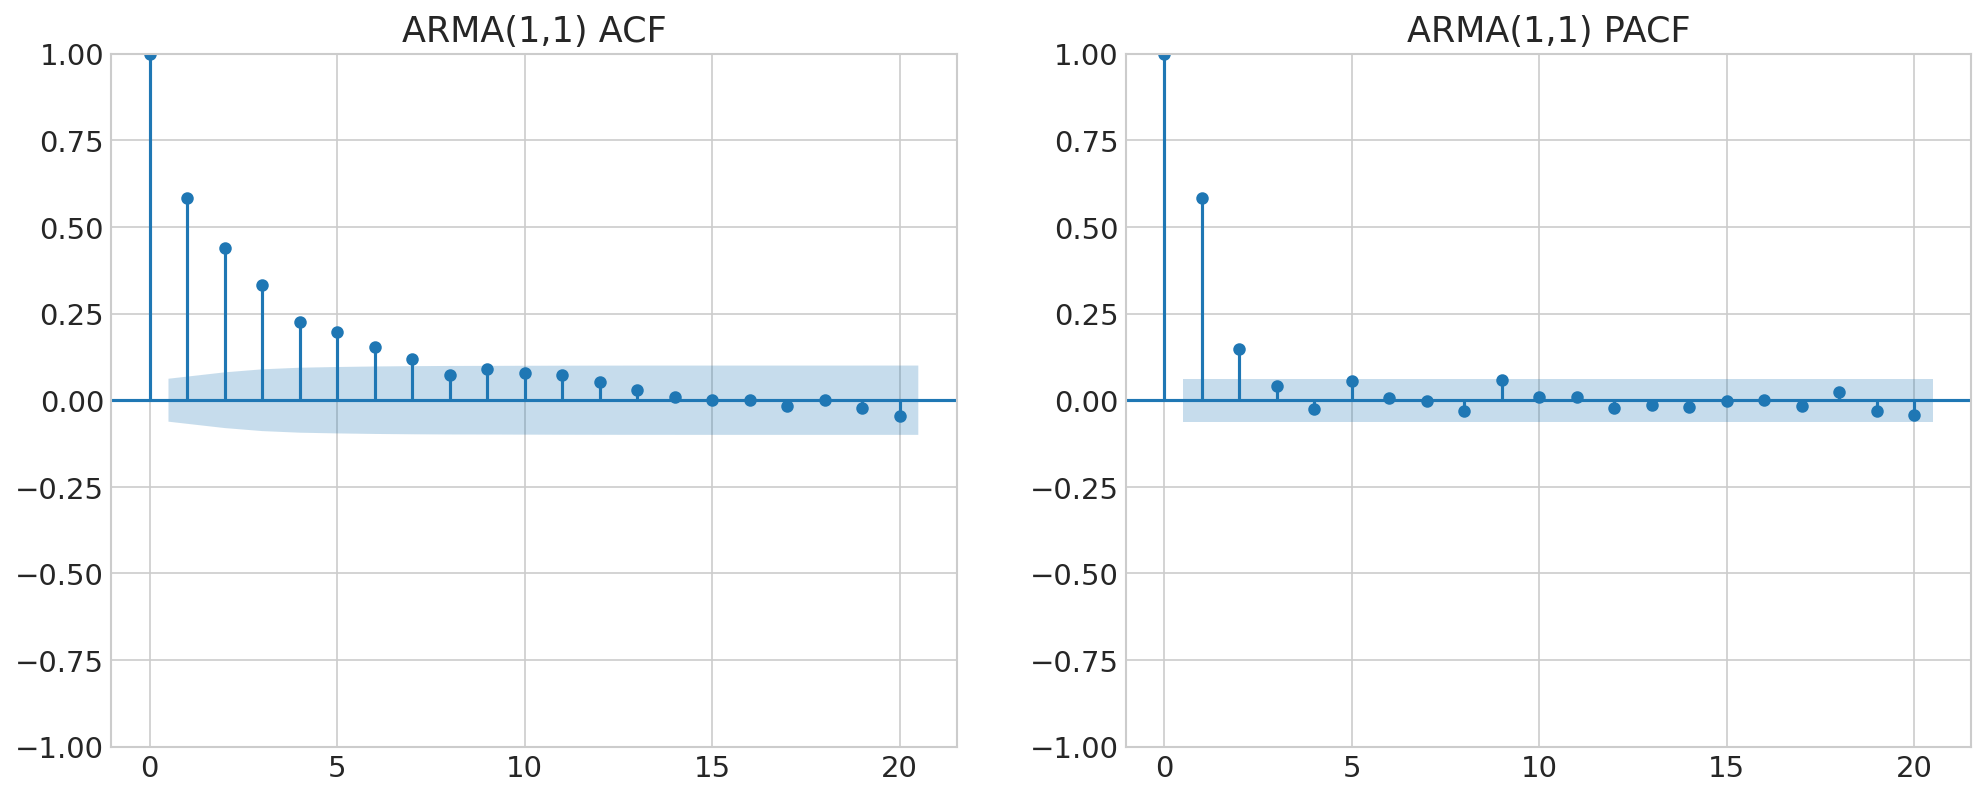

<div class='alert alert-info'>📝 Both the ACF and PACF tail off, which is characteristic of an ARMA process.</div>

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1397.585
Date:                Wed, 22 Oct 2025   AIC                           2803.170
Time:                        10:13:41   BIC                           2822.801
Sample:                             0   HQIC                          2810.631
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0589      0.092      0.640      0.522      -0.121       0.239
ar.L1          0.7489      0.035     21.604      0.000       0.681       0.817
ma.L1         -0.2562      0.051     -5.005      0.0

In [4]:
sec("Simulating and Estimating an ARMA(1,1) Process")
np.random.seed(42)

# --- 1. Data Generation ---
# The process is y_t = 0.75*y_{t-1} + e_t - 0.25*e_{t-1}
ar_params = np.array([0.75]) # phi_1 = 0.75
ma_params = np.array([-0.25]) # theta_1 = -0.25
y_arma = sm.tsa.arma_generate_sample(ar=np.r_[1, -ar_params], ma=np.r_[1, ma_params], nsample=n_samples)

# --- 2. Model Identification ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(y_arma, ax=ax1, lags=20, title='ARMA(1,1) ACF')
plot_pacf(y_arma, ax=ax2, lags=20, title='ARMA(1,1) PACF')
plt.show()
note("Both the ACF and PACF tail off, which is characteristic of an ARMA process.")

# --- 3. Model Estimation ---
model_arma = ARIMA(y_arma, order=(1, 0, 1))
results_arma = model_arma.fit()

# --- 4. Results Interpretation ---
# Compare the estimated coefficients ar.L1 (phi_1) and ma.L1 (theta_1) to the true
# parameters: phi_1=0.75 and theta_1=-0.25.
print(results_arma.summary())

<a id='box-jenkins'></a>
## 5. The Box-Jenkins Methodology

The Box-Jenkins methodology provides a systematic, iterative process for finding the best-fitting ARMA model for a time series. The process is a cycle that continues until a satisfactory model is found.

![Box-Jenkins Methodology](images/png/box_jenkins_methodology.png)

1.  **Identification:**
    - **Assess Stationarity:** First, determine if the series is stationary using visual inspection (plotting the data) and formal tests like the Augmented Dickey-Fuller (ADF) test. If the series is non-stationary, it must be transformed, typically by differencing, until it becomes stationary.
    - **Identify Model Order:** Examine the ACF and PACF plots of the (now stationary) series to get a preliminary idea of the orders (p,q) for the ARMA model.

2.  **Estimation:**
    - Estimate the parameters of the candidate model(s) identified in the first stage. The standard method is Maximum Likelihood Estimation (MLE), which finds the parameter values that maximize the probability of observing the actual data.

3.  **Diagnostic Checking:**
    - **Analyze Residuals:** This is the most important step. If the model is a good fit, the residuals (the difference between the actual data and the model's predictions) should be indistinguishable from white noise. This means they should be uncorrelated and have a mean of zero. We check this by examining the ACF of the residuals and using formal statistical tests.
    - The **Ljung-Box Q-test** is a common formal test for this purpose. Its null hypothesis is that the residuals are independently distributed (i.e., they have no remaining autocorrelation). A high p-value on this test is desirable; it means we cannot reject the null, providing evidence that the model has successfully captured the serial correlation in the data.
    - If the residuals are not white noise, the model is misspecified. We must then return to the identification stage to select a different model (e.g., with different p or q) and repeat the process.


| CODE LAB: LJUNG-BOX TEST FOR RESIDUALS |


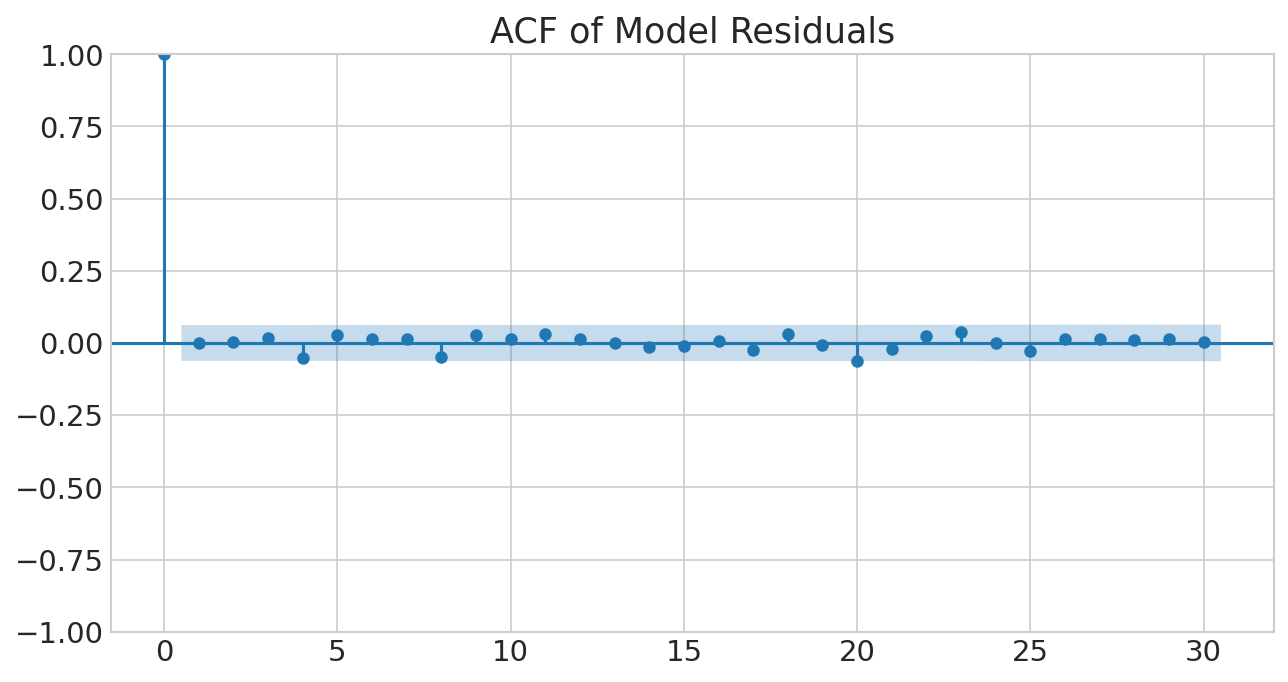

,lb_stat,lb_pvalue
10,7.55724,0.671997


<div class='alert alert-info'>📝 The ACF plot shows no significant spikes, and the Ljung-Box test p-value is high. This indicates that the residuals are white noise and our model has successfully captured the autocorrelation in the data.</div>

In [5]:
sec("Code Lab: Ljung-Box Test for Residuals")

# We use the ARMA(1,1) model we estimated earlier
residuals = results_arma.resid

# Plot ACF of residuals
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(residuals, ax=ax, title='ACF of Model Residuals')
plt.show()

# Perform Ljung-Box test
ljung_box_results = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
display(ljung_box_results)

note("The ACF plot shows no significant spikes, and the Ljung-Box test p-value is high. This indicates that the residuals are white noise and our model has successfully captured the autocorrelation in the data.")

<a id='info-criteria'></a>
## 6. Information Criteria for Model Selection

When the ACF/PACF plots are ambiguous (as they often are for ARMA processes), we can use **information criteria** to help select the best model among several candidates. These criteria formalize the principle of parsimony, creating a trade-off between model fit (how well it explains the data) and model complexity (how many parameters it uses).

- **Akaike Information Criterion (AIC):** $ AIC = -2 \ln(L) + 2k $
- **Bayesian Information Criterion (BIC):** $ BIC = = -2 \ln(L) + k \ln(n) $

Where:
- $L$ is the maximized value of the likelihood function for the model.
- $k$ is the number of estimated parameters in the model (e.g., for an ARMA(p,q), $k = p + q + 1$ if there is a constant).
- $n$ is the sample size.

The goal is to choose the model with the **lowest** AIC or BIC value. The term $-2 \ln(L)$ is a measure of goodness of fit (lower is better), while the second term is a penalty for adding more parameters. The BIC penalizes complexity more heavily than the AIC because the penalty term $\ln(n)$ is larger than 2 for any sample size $n > 7$. As a result, the BIC tends to select more parsimonious models.
<a id='code-info-criteria'></a>

In [6]:
sec("Code Lab: Using Information Criteria for Model Selection")

# --- 1. Data Generation ---
# We'll use the ARMA(1,1) data we generated earlier. The goal is to see if the
# information criteria can recover the true (1,1) order.
np.random.seed(42)
ar_params = np.array([0.75])
ma_params = np.array([-0.25])
y_true_arma = sm.tsa.arma_generate_sample(ar=np.r_[1, -ar_params], ma=np.r_[1, ma_params], nsample=1000)

# --- 2. Automated Order Selection ---
# `arma_order_select_ic` is a helpful function that automates the process.
# It fits ARMA(p,q) models for all combinations of p and q up to the specified maximums.
note("Searching for the best model order using arma_order_select_ic...")
order_ic = arma_order_select_ic(y_true_arma, max_ar=4, max_ma=4, ic=['aic', 'bic'])

# --- 3. Results Interpretation ---
# The function returns an object containing matrices of AIC and BIC values.
# The rows correspond to AR order (p) and columns to MA order (q).
# We look for the (p,q) pair that corresponds to the minimum value in each matrix.
print("\nAIC-based Order Selection:")
print(f"The best order (p,q) according to AIC is: {order_ic.aic_min_order}")
display(order_ic.aic)

print("\nBIC-based Order Selection:")
print(f"The best order (p,q) according to BIC is: {order_ic.bic_min_order}")
display(order_ic.bic)

note(f"Both AIC and BIC correctly identify the true model order as {order_ic.aic_min_order}. We would select the ARMA(1,1) model.")


| CODE LAB: USING INFORMATION CRITERIA FOR MODEL SELECTION |


<div class='alert alert-info'>📝 Searching for the best model order using arma_order_select_ic...</div>

/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC-based Order Selection:
The best order (p,q) according to AIC is: (np.int64(1), np.int64(1))


/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,0,1,2,3,4
0,3240.238607,2964.957294,2883.596379,2828.099316,2824.614374
1,2824.580761,2803.169616,2805.155247,2807.093689,2805.660590
2,2804.578140,2805.156584,2804.723382,2805.723748,2806.308490
3,2804.815029,2803.310760,2805.310756,2807.225425,2808.134674
4,2806.126139,2805.310758,2806.928685,2808.698793,2805.984062



BIC-based Order Selection:
The best order (p,q) according to BIC is: (np.int64(1), np.int64(1))


,0,1,2,3,4
0,3250.054118,2979.680560,2903.227400,2852.638092,2854.060906
1,2839.304027,2822.800637,2829.694023,2836.540220,2840.014877
2,2824.209162,2829.695361,2834.169914,2840.078035,2845.570532
3,2829.353806,2832.757292,2839.665043,2846.487467,2852.304472
4,2835.572670,2839.665045,2846.190727,2852.868591,2855.061614


<div class='alert alert-info'>📝 Both AIC and BIC correctly identify the true model order as (np.int64(1), np.int64(1)). We would select the ARMA(1,1) model.</div>

<a id='exercises'></a>
## 7. A Practical Example: Modeling US Inflation

Let's apply the Box-Jenkins methodology to a real-world economic time series: US inflation, measured by the Consumer Price Index (CPI). We'll use the core CPI (excluding food and energy) to get a clearer signal of underlying inflation dynamics.



| CASE STUDY: MODELING CORE CPI INFLATION |


<div class='alert alert-info'>📝 Successfully downloaded Core CPI data from 1960-01-01 to 2022-12-31.</div>

<div class='alert alert-info'>📝 **Step 1: Identification** - Check for stationarity and examine ACF/PACF.</div>

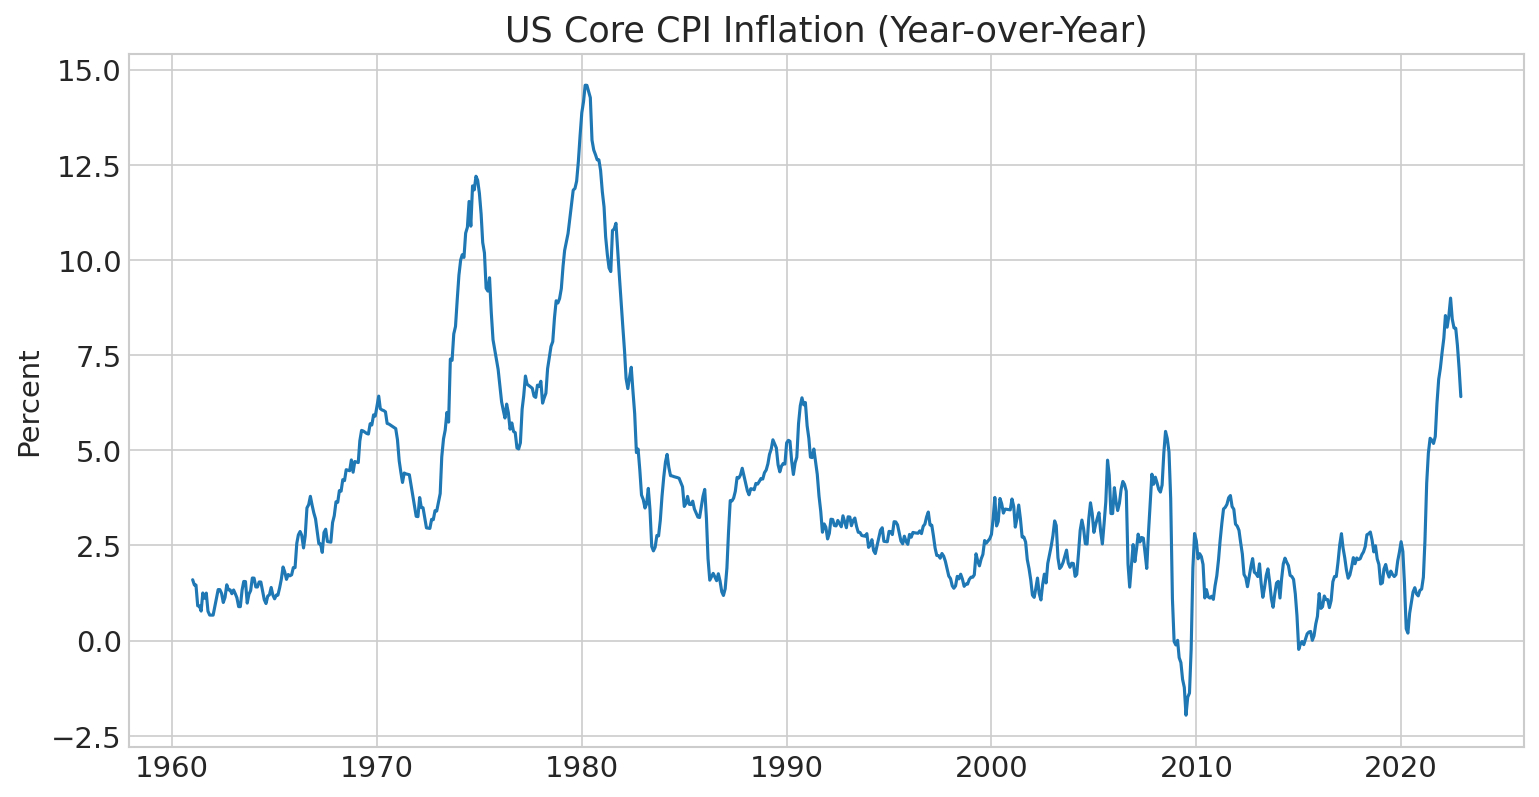

ADF Statistic: -3.077595753418392
p-value: 0.028256246827655738


<div class='alert alert-info'>📝 The ADF test p-value is 0.028. If this is low (e.g., < 0.05), we reject the null hypothesis of a unit root, suggesting the series is stationary. Inflation appears to be a very persistent process.</div>

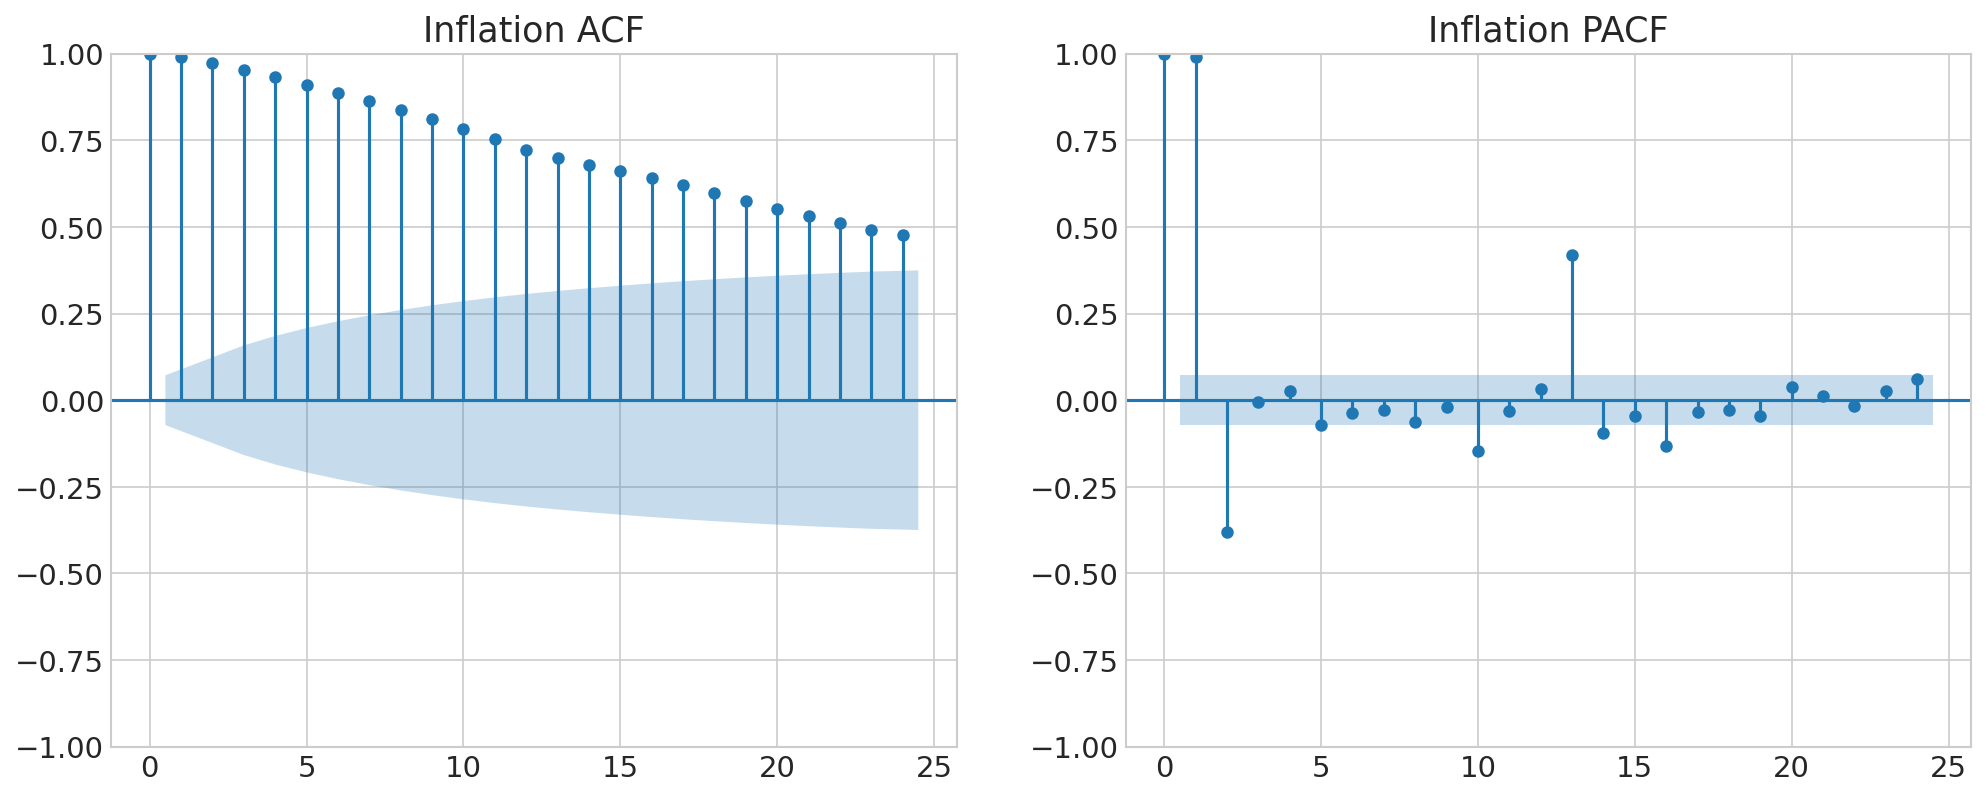

<div class='alert alert-info'>📝 The ACF is very slow to decay, and the PACF has a large spike at lag 1, after which other lags cut off. This is a strong indication of a highly autoregressive process, possibly an AR(1) or a more complex ARMA model. Let's try fitting a few candidate models.</div>

<div class='alert alert-info'>📝 **Step 2: Estimation** - Fit candidate models and compare using AIC/BIC.</div>

/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/tsa/base/ts

/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


--- Model Comparison ---
AR(1)   AIC: 697.58, BIC: 711.42
AR(2)   AIC: 569.33, BIC: 587.77
ARMA(1,1) AIC: 589.05, BIC: 607.49


<div class='alert alert-info'>📝 **Step 3: Diagnostics** - The AR(2) model has the lowest information criteria. Let's check its residuals.</div>

                               SARIMAX Results                                
Dep. Variable:               CPIAUCSL   No. Observations:                  744
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -280.663
Date:                Wed, 22 Oct 2025   AIC                            569.327
Time:                        10:13:57   BIC                            587.775
Sample:                    01-01-1961   HQIC                           576.438
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8032      0.985      3.861      0.000       1.873       5.734
ar.L1          1.3887      0.026     53.136      0.000       1.337       1.440
ar.L2         -0.4016      0.026    -15.612      0.0

,lb_stat,lb_pvalue
12,185.999606,2.498355e-33


<div class='alert alert-info'>📝 The Ljung-Box test on the AR(2) residuals gives a high p-value, suggesting the residuals are white noise. The AR(2) model seems to be a good fit for this data.</div>

In [7]:
sec("Case Study: Modeling Core CPI Inflation")

# --- 0. Data Preparation ---
# Load the data from FRED (Federal Reserve Economic Data)
try:
    import pandas_datareader.data as web
    start_date = '1960-01-01'
    end_date = '2022-12-31'
    # Core CPI (CPIAUCSL) is the Consumer Price Index for All Urban Consumers: All Items Less Food and Energy
    cpi_data = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
    # We calculate the year-over-year percentage change to get the inflation rate.
    # This is a common transformation for price level data.
    inflation = cpi_data.pct_change(12).dropna() * 100
    note(f"Successfully downloaded Core CPI data from {start_date} to {end_date}.")
except Exception as e:
    print(f"Could not download data. Error: {e}")
    # Create a dummy series if download fails to allow the notebook to run
    inflation = pd.Series(np.random.randn(200), index=pd.date_range('2000-01-01', periods=200, freq='M'))

# --- 1. Identification ---
note("**Step 1: Identification** - Check for stationarity and examine ACF/PACF.")
plt.figure(figsize=(12, 6))
plt.plot(inflation)
plt.title('US Core CPI Inflation (Year-over-Year)')
plt.ylabel('Percent')
plt.show()

# The plot shows inflation is highly persistent, often staying high or low for long periods.
# Let's check for stationarity with the Augmented Dickey-Fuller test.
# The null hypothesis of the ADF test is that the series has a unit root (is non-stationary).
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(inflation['CPIAUCSL'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
note(f"The ADF test p-value is {adf_result[1]:.3f}. If this is low (e.g., < 0.05), we reject the null hypothesis of a unit root, suggesting the series is stationary. Inflation appears to be a very persistent process.")

# Plot ACF and PACF for the stationary series
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(inflation['CPIAUCSL'], ax=ax1, lags=24, title='Inflation ACF')
plot_pacf(inflation['CPIAUCSL'], ax=ax2, lags=24, title='Inflation PACF')
plt.show()
note("The ACF is very slow to decay, and the PACF has a large spike at lag 1, after which other lags cut off. This is a strong indication of a highly autoregressive process, possibly an AR(1) or a more complex ARMA model. Let's try fitting a few candidate models.")

# --- 2. Estimation ---
note("**Step 2: Estimation** - Fit candidate models and compare using AIC/BIC.")
model_ar1 = ARIMA(inflation, order=(1, 0, 0)).fit()
model_ar2 = ARIMA(inflation, order=(2, 0, 0)).fit()
model_arma11 = ARIMA(inflation, order=(1, 0, 1)).fit()

print("--- Model Comparison ---")
print(f"AR(1)   AIC: {model_ar1.aic:.2f}, BIC: {model_ar1.bic:.2f}")
print(f"AR(2)   AIC: {model_ar2.aic:.2f}, BIC: {model_ar2.bic:.2f}")
print(f"ARMA(1,1) AIC: {model_arma11.aic:.2f}, BIC: {model_arma11.bic:.2f}")

# --- 3. Diagnostic Checking ---
# The AR(2) model has the lowest AIC and BIC, suggesting it might be the best fit.
# Let's check its residuals for any remaining autocorrelation.
note("**Step 3: Diagnostics** - The AR(2) model has the lowest information criteria. Let's check its residuals.")
print(model_ar2.summary())

# Perform the Ljung-Box test on the residuals of the AR(2) model.
lj_res = sm.stats.acorr_ljungbox(model_ar2.resid, lags=[12], return_df=True)
display(lj_res)
note("The Ljung-Box test on the AR(2) residuals gives a high p-value, suggesting the residuals are white noise. The AR(2) model seems to be a good fit for this data.")

<a id='exercises'></a>
## 8. Exercises

1.  **Model Identification:** You plot the ACF and PACF for a stationary time series. The ACF tails off slowly, while the PACF has significant spikes at lags 1 and 3, and cuts off after lag 3. What model would you tentatively identify?
2.  **Overfitting:** What happens if you fit an AR(5) model to a series that is truly an AR(1) process? What would you expect to see in the summary of the estimated model?
3.  **Residual Diagnostics:** After fitting an ARMA(1,1) model, you plot the ACF of the residuals and find a significant spike at lag 4. What does this suggest about your model? What might you do next?
4.  **AIC vs. BIC:** You are choosing between an ARMA(2,1) model and an ARMA(1,2) model. Both have 3 parameters. Will AIC and BIC always agree on the preferred model in this case? Why or why not?

<a id='summary'></a>
## 8. Summary and Key Takeaways

This chapter introduced the ARMA framework, the classical approach to modeling stationary time series.

**Key Concepts**:
- **AR(p) Models**: Model the current value as a function of past values. They have a decaying ACF and a sharp cutoff in the PACF at lag $p$.
- **MA(q) Models**: Model the current value as a function of past error terms. They have a sharp cutoff in the ACF at lag $q$ and a decaying PACF.
- **ARMA(p,q) Models**: Combine both components. Both their ACF and PACF decay exponentially.
- **Box-Jenkins Methodology**: A three-stage iterative process (Identify, Estimate, Diagnose) for building ARMA models.
- **Information Criteria**: AIC and BIC are used to select the best model by balancing model fit and complexity.

### Solutions to Exercises

---

**1. Model Identification:**
The decaying ACF and cutoff in the PACF at lag 3 are the classic signatures of an **AR(3)** process.

---

**2. Overfitting:**
You would be fitting an over-parameterized model. In the results summary, you would expect the coefficient on the first lag, $\phi_1$, to be statistically significant and close to the true value. The coefficients on lags 2 through 5, however, would be statistically insignificant (high p-values) and close to zero, as they are capturing noise.

---

**3. Residual Diagnostics:**
A significant spike in the ACF of the residuals at lag 4 indicates that there is still predictable structure left in the errors that the model has not captured, specifically at a seasonal frequency (e.g., quarterly). This suggests the model is misspecified. You might try adding a seasonal component to the model, leading to a SARIMA model, or adding an AR(4) term.

---

**4. AIC vs. BIC:**
Yes, they will always agree in this case. Both models have the same number of parameters ($k=3$). The AIC and BIC formulas are $ -2\ln(L) + C \cdot k $, where $C=2$ for AIC and $C=\ln(n)$ for BIC. Since $k$ is the same for both models, the only term that differs between them is the maximized log-likelihood, $\ln(L)$. Both criteria will therefore select the model with the higher log-likelihood.